Galite panaudoti davo duomenų rinkinį arba pasiūlytą EuroSAT.
1. Parisisiųskite duomenis ir pasižiūrėkite bendrą informaciją (kiek yra duomenų kiekvienoje klasėje, kaip atrodo paveikslėlių pavyzdžiai)
2. Pasiruoškite duomenis (išsiskaidykite į atskiras treniravimosi, validacijos ir testavimo duomenis, augmentuokite, normalizuokite ir kt.)
3. Sudarykite modelio architektūrą ar kelias (turi būti bent keli konvoliuciniai sluoksniai, bent keli pooling sluoksniai, įterpkite Droput sluoksnį (ius), pritaikykite L2 normalizaciją).
4. Paieškokite CNN architektūrų internete ir pabandykite pritaikyti šio uždavinio sprendimui. Palyginkite gautus rezultatus.
5. Pabandykite skirtingus hyperparametrus (mokymosi žingsnio dydis, epochų skaičius, batch size).
6. Įvertinkite modelio tikslumą, atvaizduokite Confusion matrix bei kitas metrikas.
7. Parašykite vieną nedidelę pastraipą apie gautus rezultatus.

Apie **groups** parametrą konvoliucijose:

**groups=1** (numatytasis režimas). Visi įvesties kanalai yra susieti su visais išvesties kanalais. Pavyzdžiui, jei turite 3 įvesties kanalus ir 6 išvesties kanalus, bus 6 filtrai, kurių kiekvienas taikomas visiems 3 įvesties kanalams.

`conv = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, groups=1)`

**groups=C** (depthwise convolution). Kiekvienas įvesties kanalas apdorojamas atskirai savo filtru. Jei turite 3 įvesties kanalus, bus naudojami 3 filtrai, kurių kiekvienas taikomas tik savo kanalui.

`conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, groups=3)`

**groups>1** (grupinis režimas). Įvesties kanalai yra padalijami į grupes. Kiekviena grupė turi savo filtrus, tačiau filtrai vienoje grupėje neveikia kitų grupių įvesties kanalų. Pavyzdžiui, jei turite 4 įvesties kanalus, 8 išvesties kanalus ir groups=2, įvesties kanalai bus padalyti į 2 grupes (po 2 kanalus), o kiekviena grupė sugeneruos 4 išvesties kanalus.

`conv = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, groups=2)`


In [ ]:
import os
import zipfile
import urllib.request

# URL adresas su EuroSAT duomenų rinkiniu
url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"

# Failo pavadinimas, kuriuo bus išsaugotas parsisiųstas zip
zip_filename = "EuroSAT.zip"

# Tikriname, ar failas jau parsisiųstas
if not os.path.exists(zip_filename):
    print("Parsisiunčiama EuroSAT duomenų rinkinys...")
    urllib.request.urlretrieve(url, zip_filename)
    print("Parsisiuntimas baigtas!")
else:
    print("Failas jau egzistuoja:", zip_filename)

# Nurodome direktoriją, į kurią bus išarchyvuota (galite pakeisti, pvz., į 'EuroSAT_dataset')
extract_dir = "EuroSAT_dataset"

# Tikriname, ar duomenys jau išarchyvuoti
if not os.path.exists(extract_dir):
    print("Išarchyvuojama...")
    with zipfile.ZipFile(zip_filename, "r") as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Išarchyvavimas baigtas!")
else:
    print("Duomenys jau išarchyvuoti:", extract_dir)


Parsisiunčiama EuroSAT duomenų rinkinys...
Parsisiuntimas baigtas!
Išarchyvuojama...
Išarchyvavimas baigtas!


# Prepare a dataset

In [ ]:
def count_jpg_files(root_dir):

    target_dir = os.path.join(root_dir, "2750")

    if not os.path.exists(target_dir):
        print(f"The directory {target_dir} does not exist.")
        return

    for dirpath, dirnames, filenames in os.walk(target_dir):
        jpg_files = [f for f in filenames if f.lower().endswith('.jpg')]
        print(f"Directory: {dirpath}, .jpg files count: {len(jpg_files)}")

root_dir = "./EuroSAT_dataset"
count_jpg_files(root_dir)




Directory: ./EuroSAT_dataset/2750, .jpg files count: 0
Directory: ./EuroSAT_dataset/2750/Forest, .jpg files count: 3000
Directory: ./EuroSAT_dataset/2750/Industrial, .jpg files count: 2500
Directory: ./EuroSAT_dataset/2750/Pasture, .jpg files count: 2000
Directory: ./EuroSAT_dataset/2750/SeaLake, .jpg files count: 3000
Directory: ./EuroSAT_dataset/2750/HerbaceousVegetation, .jpg files count: 3000
Directory: ./EuroSAT_dataset/2750/Residential, .jpg files count: 3000
Directory: ./EuroSAT_dataset/2750/PermanentCrop, .jpg files count: 2500
Directory: ./EuroSAT_dataset/2750/AnnualCrop, .jpg files count: 3000
Directory: ./EuroSAT_dataset/2750/Highway, .jpg files count: 2500
Directory: ./EuroSAT_dataset/2750/River, .jpg files count: 2500


In [ ]:
import random
import shutil

def create_train_val_test(root_dir):
  directories = ["train", "test", "val"]

  for dir in directories:

    try:
      target_dir = os.path.join(root_dir, dir)
      os.mkdir(target_dir)
      print(f"Directory '{target_dir}' created successfully.")
    except FileExistsError:
      print(f"Directory '{target_dir}' already exists.")
    except PermissionError:
      print(f"Permission denied: Unable to create '{target_dir}'.")
    except Exception as e:
      print(f"An error occurred: {e}")

def split_data_into_folders(root_dir):
    source_dir = os.path.join(root_dir, "2750")
    train_dir = os.path.join(root_dir, "train")
    val_dir = os.path.join(root_dir, "val")
    test_dir = os.path.join(root_dir, "test")

    # Loop through all directories in the source_dir
    for sub_dir in os.listdir(source_dir):
        sub_dir_path = os.path.join(source_dir, sub_dir)
        if not os.path.isdir(sub_dir_path):  # Skip non-directory files
            continue

        # Get a list of all .jpg files in the subdirectory
        all_files = [f for f in os.listdir(sub_dir_path) if f.lower().endswith(".jpg")]
        random.shuffle(all_files)  # Shuffle files for random distribution

        # Split the files into 80% train, 10% val, and 10% test
        train_split = int(0.8 * len(all_files))
        val_split = int(0.9 * len(all_files))

        train_files = all_files[:train_split]
        val_files = all_files[train_split:val_split]
        test_files = all_files[val_split:]

        # Copy files into the respective directories
        for file_list, target_dir in [(train_files, train_dir), (val_files, val_dir), (test_files, test_dir)]:
            target_sub_dir = os.path.join(target_dir, sub_dir)
            os.makedirs(target_sub_dir, exist_ok=True)  # Create sub-directory in the target folder if it doesn't exist

            for file_name in file_list:
                src_file = os.path.join(sub_dir_path, file_name)
                dest_file = os.path.join(target_sub_dir, file_name)
                shutil.copy2(src_file, dest_file)

        print(f"Processed '{sub_dir}': {len(train_files)} train, {len(val_files)} val, {len(test_files)} test.")

root_dir = "./EuroSAT_dataset"

# Create train, test, and val directories
create_train_val_test(root_dir)

split_data_into_folders(root_dir)


Directory './EuroSAT_dataset/train' created successfully.
Directory './EuroSAT_dataset/test' created successfully.
Directory './EuroSAT_dataset/val' created successfully.
Processed 'Forest': 2400 train, 300 val, 300 test.
Processed 'Industrial': 2000 train, 250 val, 250 test.
Processed 'Pasture': 1600 train, 200 val, 200 test.
Processed 'SeaLake': 2400 train, 300 val, 300 test.
Processed 'HerbaceousVegetation': 2400 train, 300 val, 300 test.
Processed 'Residential': 2400 train, 300 val, 300 test.
Processed 'PermanentCrop': 2000 train, 250 val, 250 test.
Processed 'AnnualCrop': 2400 train, 300 val, 300 test.
Processed 'Highway': 2000 train, 250 val, 250 test.
Processed 'River': 2000 train, 250 val, 250 test.


# Load data and analyze

Klasių imčių dydžiai: {'AnnualCrop': 2400, 'Forest': 2400, 'HerbaceousVegetation': 2400, 'Highway': 2000, 'Industrial': 2000, 'Pasture': 1600, 'PermanentCrop': 2000, 'Residential': 2400, 'River': 2000, 'SeaLake': 2400}


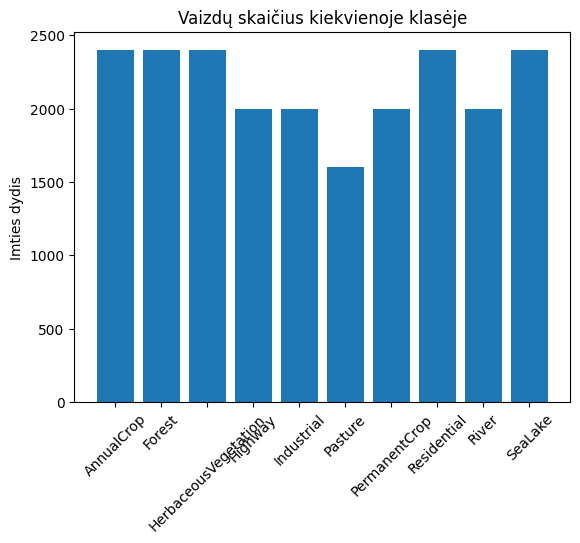

In [ ]:
import matplotlib.pyplot as plt

classes = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial", "Pasture",
"PermanentCrop", "Residential", "River", "SeaLake"]

class_counts = {cls: len(os.listdir(os.path.join("./EuroSAT_dataset/train", cls))) for cls in classes}
print("Klasių imčių dydžiai:", class_counts)

plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.ylabel("Imties dydis")
plt.title("Vaizdų skaičius kiekvienoje klasėje")
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class CustomImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.img_paths = self.get_img_paths()
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path, label = self.img_paths[idx]  # Get the image path and its label
        try:
            image = Image.open(img_path).convert("RGB")  # Ensure image is converted to RGB
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            raise IndexError(f"Could not load image at index {idx}")

    def get_img_paths(self):
        img_paths = []
        for cls_name in self.classes:
            cls_path = os.path.join(self.root_dir, cls_name)
            if not os.path.isdir(cls_path):
                continue
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(self.root_dir, cls_name, img_name)
                img_paths.append((img_path, self.class_to_idx[cls_name]))
        return img_paths

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.RandomResizedCrop(size=(64, 64)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                           saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# - Validacijos ir testavimo rinkiniams (be augmentacijos)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_path = './EuroSAT_dataset/train'
train_dataset = CustomImageFolderDataset(train_path, train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

print("Train data: ", train_dataset.__len__())

test_path = './EuroSAT_dataset/test'
test_dataset = CustomImageFolderDataset(test_path, transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0)

print("Test data: ", test_dataset.__len__())

val_path = './EuroSAT_dataset/test'
val_dataset = CustomImageFolderDataset(val_path, transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)

print("Validation data: ", val_dataset.__len__())

################################################################################
#
#from torchvision import datasets, transforms
#from torch.utils.data import DataLoader, random_split
#
# Transformacijos: normalizavimas ir dydžio keitimas
#transform_second = transforms.Compose([
#    transforms.Resize((64, 64)),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
#])
#
# Sukuriame PyTorch dataset
#full_dataset = datasets.ImageFolder("./EuroSAT_dataset/2750", transform=transform_second)
#
# Padaliname į treniravimo, validacijos ir testavimo rinkinius
#train_size = int(0.8 * len(full_dataset))
#val_size = int(0.1 * len(full_dataset))
#test_size = len(full_dataset) - train_size - val_size
#
#train_dataset_second, val_dataset_second, test_dataset_second = random_split(full_dataset, [train_size, val_size, test_size])
#
# Sukuriame duomenų įkėlimą (DataLoader)
#train_loader_second = DataLoader(train_dataset_second, batch_size=32, shuffle=True)
#val_loader_second = DataLoader(val_dataset_second, batch_size=32, shuffle=False)
#test_loader_second = DataLoader(test_dataset_second, batch_size=32, shuffle=False)
#
#print(f"Treniravimo rinkinys: {len(train_dataset_second)} vaizdų")
#print(f"Validacijos rinkinys: {len(val_dataset_second)} vaizdų")
#print(f"Testavimo rinkinys: {len(test_dataset_second)} vaizdų")




Train data:  21600
Test data:  2700
Validation data:  2700
Treniravimo rinkinys: 21600 vaizdų
Validacijos rinkinys: 2700 vaizdų
Testavimo rinkinys: 2700 vaizdų


Example image path: ./EuroSAT_dataset/train/AnnualCrop/AnnualCrop_310.jpg
Default image size (width, height): (64, 64)
Default image mode: RGB


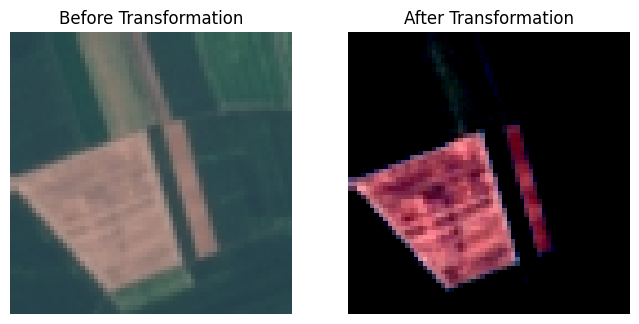

In [ ]:
import os
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

example_img_path = train_dataset.img_paths[0][0]  # Get the first image path
print(f"Example image path: {example_img_path}")

image = Image.open(example_img_path)

print(f"Default image size (width, height): {image.size}")
print(f"Default image mode: {image.mode}")  # Typically RGB

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Before Transformation")
plt.axis("off")

transformed_image = transform(image)

# Convert transformed image (tensor) back to a displayable format
transformed_image_np = transformed_image.permute(1, 2, 0).numpy()  # Convert CHW to HWC for matplotlib

plt.subplot(1, 2, 2)
plt.imshow(transformed_image_np)
plt.title("After Transformation")
plt.axis("off")
plt.show()


# Model Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device="cuda" if torch.cuda.is_available() else "cpu"

class SatCNN(nn.Module):
    def __init__(self):
        super(SatCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 3 kanalai (RGB), 32 filtrų, 3x3 kernel/filtras
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 32 filtrai
        self.dropout1 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 64 filtrai
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 baseinavimas
        self.fc1 = nn.Linear(64 * 8 * 8, 64)  # Fully connected sluoksnis
        self.dropout2 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(64, len(classes))  # Klasės skaičius

        """
                    nn.Conv2d(in_channels=3,  # Input channels (e.g., RGB color)
                      out_channels=32,  # Number of filters in this layer
                      kernel_size=3,    # Size of each filter (3x3)
                      stride=1,         # Stride (movement) of the filter
                      padding=1),       # Padding to maintain the input size
        """

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + ReLU + Pool # 64x64 -> 32x32
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + ReLU + Pool # 32x32 -> 16x16
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv3(x)))  # Conv3 + ReLU + Pool # 16x16 -> 8x8
        x = x.view(-1, 64 * 8 * 8)  # Flatten
        x = F.relu(self.fc1(x))  # Fully connected sluoksnis
        x = self.dropout2(x)
        x = self.fc2(x)  # Klasifikavimo sluoksnis
        return x

model = SatCNN()
print(model)

from torchsummary import summary

# Santrauka su sluoksnių išvesties formomis ir parametrų skaičiumi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

from torchsummary import summary
summary(model, (3, 64, 64), device=device.type)  # Pridėkite `device` argumentą

SatCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
         MaxPool2d-2           [-1, 16, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           4,640
         MaxPool2d-4           [-1, 32, 16, 16]               0
           Dropout-5           [-1, 32, 16, 16]               0
            Conv

# Modelio treniravimas

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    # Aptinkame GPU arba CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Naudojamas įrenginys: {device}")

    # Perkeliame modelį į pasirinktą įrenginį
    model = model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        #Treniruojame
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            # Perkeliame duomenis į GPU arba CPU
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            #Apskaičiuojam, kaip turi būti atnaujinti svoriai pagal gautą loss
            loss.backward()

            #Atnaujinam svorius
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        # Validacija
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                # Perkeliame duomenis į GPU arba CPU
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoka {epoch + 1}/{epochs}")
        print(f"   Treniravimo nuostolis: {train_losses[-1]:.4f}, Tikslumas: {train_accuracies[-1]:.2f}%")
        print(f"   Validacijos nuostolis: {val_losses[-1]:.4f}, Tikslumas: {val_accuracies[-1]:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer)


Naudojamas įrenginys: cuda
Epoka 1/10
   Treniravimo nuostolis: 1.6739, Tikslumas: 36.42%
   Validacijos nuostolis: 1.3355, Tikslumas: 50.78%
Epoka 2/10
   Treniravimo nuostolis: 1.3382, Tikslumas: 50.44%
   Validacijos nuostolis: 1.1639, Tikslumas: 60.41%
Epoka 3/10
   Treniravimo nuostolis: 1.2164, Tikslumas: 56.47%
   Validacijos nuostolis: 1.0669, Tikslumas: 64.37%
Epoka 4/10
   Treniravimo nuostolis: 1.1292, Tikslumas: 59.69%
   Validacijos nuostolis: 0.9151, Tikslumas: 66.04%
Epoka 5/10
   Treniravimo nuostolis: 1.0672, Tikslumas: 62.69%
   Validacijos nuostolis: 0.9165, Tikslumas: 68.96%
Epoka 6/10
   Treniravimo nuostolis: 1.0331, Tikslumas: 64.38%
   Validacijos nuostolis: 0.8135, Tikslumas: 69.85%
Epoka 7/10
   Treniravimo nuostolis: 0.9955, Tikslumas: 65.02%
   Validacijos nuostolis: 0.7818, Tikslumas: 71.56%
Epoka 8/10
   Treniravimo nuostolis: 0.9733, Tikslumas: 66.02%
   Validacijos nuostolis: 0.7456, Tikslumas: 74.07%
Epoka 9/10
   Treniravimo nuostolis: 0.9441, Tiksluma

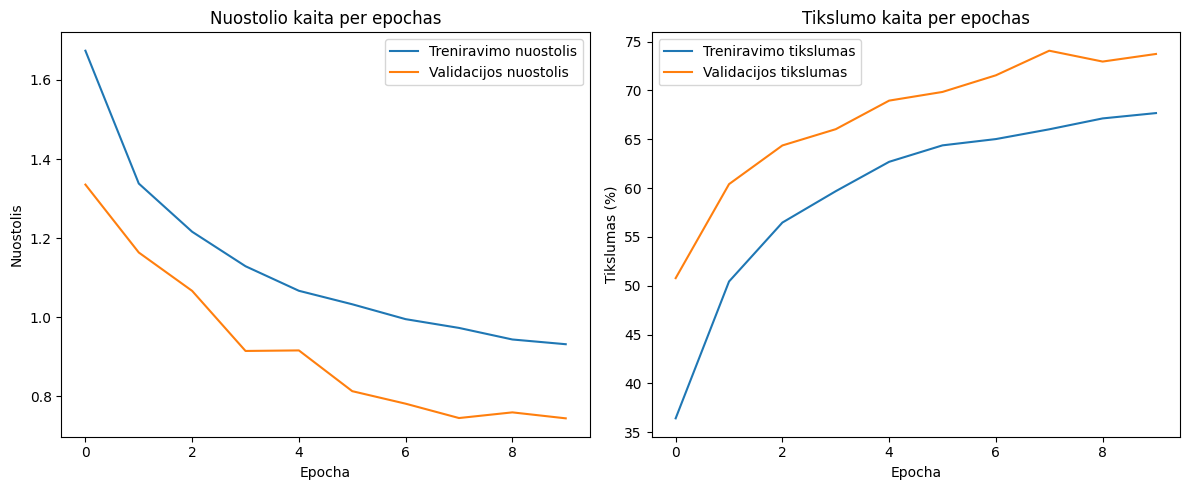

In [ ]:
# Grafikai
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Treniravimo nuostolis")
plt.plot(val_losses, label="Validacijos nuostolis")
plt.xlabel("Epocha")
plt.ylabel("Nuostolis")
plt.title("Nuostolio kaita per epochas")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Treniravimo tikslumas")
plt.plot(val_accuracies, label="Validacijos tikslumas")
plt.xlabel("Epocha")
plt.ylabel("Tikslumas (%)")
plt.title("Tikslumo kaita per epochas")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_model(model, test_loader, criterion):
    # Switch the model to evaluation mode
    model.eval()

    # Use the appropriate device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    test_loss = 0
    correct = 0
    total = 0

    # Disable gradient calculations
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute average loss and accuracy
    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

In [ ]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

Test Loss: 0.7441, Test Accuracy: 73.74%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_predictions))

print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=test_dataset.classes))


Confusion Matrix:
[[235   1   1   3   0  10  41   0   8   1]
 [  0 288   0   0   0   1   0   5   3   3]
 [  1  10 105   9   0   2  42 129   2   0]
 [ 11   0   1 140  12   2  23  28  33   0]
 [  0   0   0   0 184   0   1  64   1   0]
 [  0  12  10  10   0 141   7   7  12   1]
 [  3   0  21  18   1   0 175  30   2   0]
 [  0   0   0   0   0   0   0 300   0   0]
 [ 13   1   2  52   0  17   6   7 152   0]
 [  2   4   2   0   0   2   0   0  19 271]]
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.89      0.78      0.83       300
              Forest       0.91      0.96      0.94       300
HerbaceousVegetation       0.74      0.35      0.48       300
             Highway       0.60      0.56      0.58       250
          Industrial       0.93      0.74      0.82       250
             Pasture       0.81      0.70      0.75       200
       PermanentCrop       0.59      0.70      0.64       250
         Residential       0.53

In [ ]:
data_iter = iter(test_loader)
print(type(test_loader))
print(type(data_iter))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


In [ ]:
images, labels = next(data_iter)
print(labels) # 32 (it's a batch) sudaro ji 32 paveiksleliai ir atitinkamai 32 labeliai, nes mes daliname dataseti i blokus (batchus) kiekvienas skaicius - klase

tensor([4, 8, 8, 4, 4, 7, 8, 8, 2, 7, 1, 5, 0, 5, 3, 3, 4, 2, 9, 3, 5, 2, 0, 7,
        1, 1, 0, 8, 4, 4, 4, 6])


In [ ]:
print(len(images)) # 32 (batchas)

32


In [ ]:
# traukiame viena paveiksleli is batcho ir jo labeli

print("Paveikslelis: ", images[0])
print("Labelis:", labels[0])

Paveikslelis:  tensor([[[ 0.1597,  0.1597,  0.1083,  ...,  0.6563,  0.8447,  0.8961],
         [ 0.1597,  0.1426,  0.0741,  ...,  0.6049,  0.8104,  0.8447],
         [-0.0972, -0.0972, -0.0972,  ...,  0.2967,  0.5022,  0.7248],
         ...,
         [ 0.1254,  0.1426,  0.3823,  ..., -0.1657,  0.1254,  0.1597],
         [-0.1999, -0.1486,  0.2967,  ...,  0.1597,  1.1015,  0.5193],
         [-0.2856, -0.2171,  0.0398,  ..., -0.0458,  0.2111,  0.0056]],

        [[ 0.0826,  0.0826, -0.0224,  ...,  0.4678,  0.6254,  0.6254],
         [ 0.1001,  0.0826, -0.0049,  ...,  0.4853,  0.6429,  0.6604],
         [-0.0749, -0.0749, -0.1275,  ...,  0.2927,  0.4853,  0.7129],
         ...,
         [ 0.2052,  0.2227,  0.4678,  ...,  0.0126,  0.2052,  0.2052],
         [-0.0049, -0.0399,  0.3102,  ...,  0.3803,  1.2031,  0.5203],
         [-0.0749, -0.0749, -0.0049,  ...,  0.1702,  0.2927, -0.0049]],

        [[ 0.3393,  0.3393,  0.2871,  ...,  0.6182,  0.7925,  0.8099],
         [ 0.3916,  0.3742,  0

In [ ]:
# Tam kad ji atvaizduoti, butina konvertuoti i numpy array
#paveikslelis = images[30]
#print(type(paveikslelis))
#numpy_array_pav = paveikslelis.numpy()
#print(type(numpy_array_pav))

# ta pati labeliams
#labelis = labels[30]
#numpy_array_label = labelis.numpy()

def choose_an_image(id):
  image = images[id]
  label = labels[id]
  return image, label

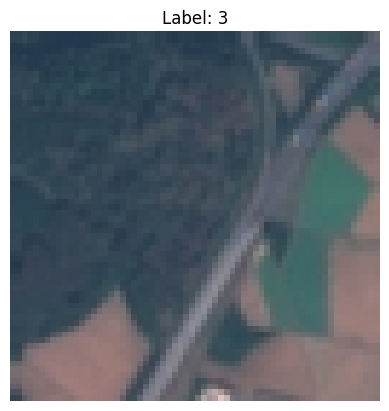

Predicted class index: 3


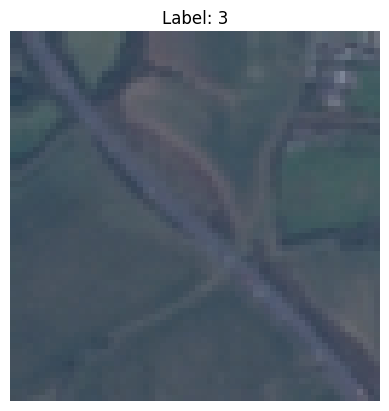

Predicted class index: 3


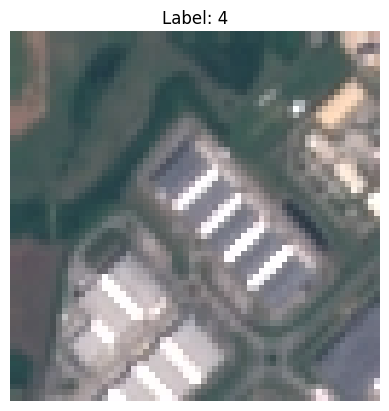

Predicted class index: 4


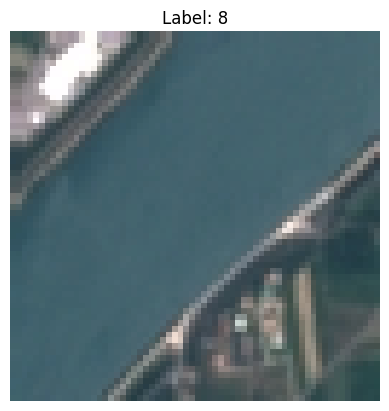

Predicted class index: 8


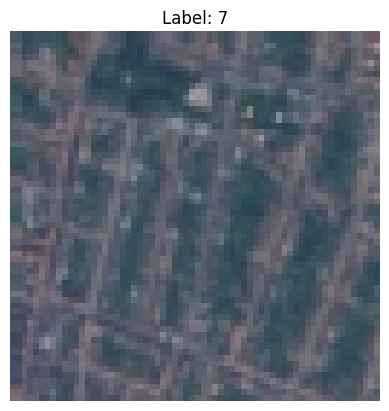

Predicted class index: 7


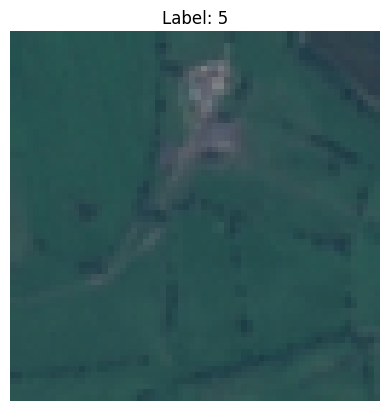

Predicted class index: 5


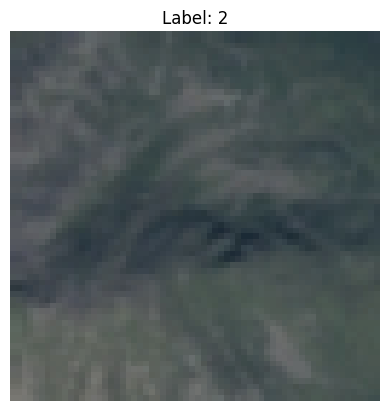

Predicted class index: 7


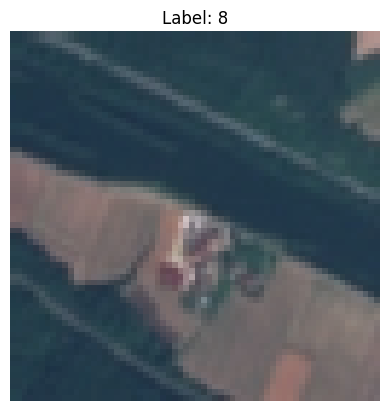

Predicted class index: 3


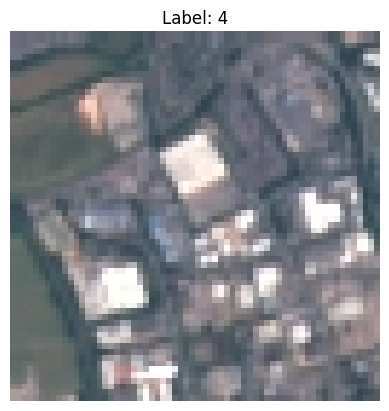

Predicted class index: 4


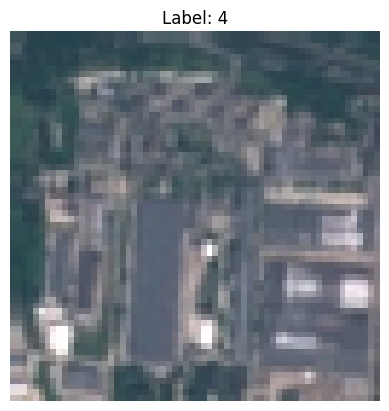

Predicted class index: 7


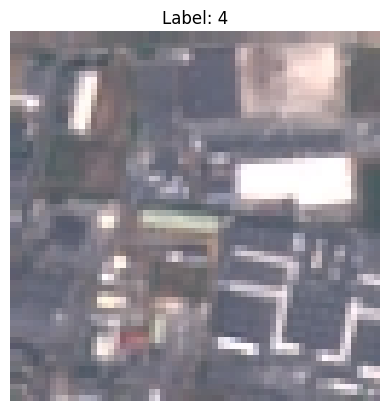

Predicted class index: 4


In [ ]:
import random

for idx in random.sample(range(0, 32), 11):

  pav, lbl = choose_an_image(idx)

  inv_normalize = transforms.Normalize(
      mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
      std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
  )

  unnormalized_image = inv_normalize(pav)
  numpy_image = unnormalized_image.permute(1, 2, 0).cpu().numpy()  # CHW -> HWC

  # Plot the image
  plt.imshow(numpy_image)
  plt.title(f"Label: {lbl.item()}")
  plt.axis("off")
  plt.show()

  # Make prediction
  with torch.no_grad():
      output = model((pav).to(device))

  # Get predicted class
  _, predicted_class = torch.max(output, 1)
  print(f"Predicted class index: {predicted_class.item()}")
